<a href="https://colab.research.google.com/github/alinespereira/alshenawy-distribution/blob/main/Alshenawy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rich

In [118]:
from pathlib import Path

for path in [
    Path("./img/classical/sim"),
    Path("./img/classical/application"),
    Path("./res/classical/sim"),
    Path("./res/classical/application"),

    Path("./img/bayesian/sim/uninformative"),
    Path("./img/bayesian/sim/informative"),
    Path("./img/bayesian/application/uninformative"),
    Path("./img/bayesian/application/informative"),

    Path("./res/bayesian/sim/uninformative"),
    Path("./res/bayesian/sim/informative"),
    Path("./res/bayesian/application/uninformative"),
    Path("./res/bayesian/application/informative"),
]:
    try:
        path.mkdir(mode=0o755, parents=True)
    except FileExistsError:
        pass

In [3]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats, optimize
import matplotlib.pyplot as plt
import seaborn as sns

from distributions.rv import a
from distributions.continuous import A
from stats import classical, bayesian
from stats.utils import summarize

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
plt.style.use("arviz-darkgrid")

# Estudo de simulação

In [38]:
REPLICATIONS: int = 1_000
SAMPLE_SIZES: list[int] = [25, 50, 100, 200, 400]
BETAS: list[float] = [0.125, 0.6, 1.0]
ALPHA: float = 0.05

In [39]:
RANDOM_SEED: int = 42
RNG: np.random.Generator = np.random.default_rng(RANDOM_SEED)

# Estudo de simulação clássico

In [41]:
simulations = {}
np.random.seed(RANDOM_SEED)

for beta in BETAS:
    simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        simulations[beta][n] = []
        print(f"\t{n = }")
        for i in range(REPLICATIONS):
            sample = rv.rvs(size=n)
            negative_log_likelihood = lambda beta_: -a(beta=beta_[0]).logpdf(sample).sum()
            simulation = classical.simulate(
                param=beta,
                negative_log_likelihood=negative_log_likelihood,
                initial_guess=0.05,
                sample_size=len(sample),
                alpha=ALPHA,
                method='L-BFGS-B',
                options={'gtol': 1e-6}
            )
            simulations[beta][n].append(simulation)

beta = 0.125
	n = 25
	n = 50
	n = 100
	n = 200
	n = 400
beta = 0.6
	n = 25
	n = 50
	n = 100
	n = 200
	n = 400
beta = 1.0
	n = 25
	n = 50
	n = 100
	n = 200
	n = 400


In [42]:
summaries = pd.DataFrame([
    summarize(simulations[beta][n])
    for beta in simulations
    for n in simulations[beta]
])

In [67]:
summaries.to_csv("res/classical/sim/summaries.csv", index=False)
summaries

,true_param,sample_size,mean,bias,mse,coverage_probability
0,0.125,25,0.227360,0.102360,0.049155,0.527
1,0.125,50,0.181848,0.056848,0.020630,0.383
2,0.125,100,0.149499,0.024499,0.007185,0.271
3,0.125,200,0.137687,0.012687,0.003454,0.184
4,0.125,400,0.131544,0.006544,0.001724,0.105
5,0.600,25,0.705931,0.105931,0.089696,0.282
6,0.600,50,0.644072,0.044072,0.035393,0.189
7,0.600,100,0.620665,0.020665,0.015287,0.153
8,0.600,200,0.612981,0.012981,0.006964,0.105
9,0.600,400,0.604833,0.004833,0.003613,0.067


In [68]:
simulation_results = pd.DataFrame([
    simulation
    for beta in simulations
    for n in simulations[beta]
    for simulation in simulations[beta][n]
])
ci = (
    pd.json_normalize(simulation_results["ci"])
    .rename(columns=lambda col: f"ci_{col}")
)
simulation_results[ci.columns] = ci
simulation_results = simulation_results.drop("ci", axis=1)
simulation_results.to_csv("res/classical/sim/simulations.csv", index=False)
simulation_results

,sample_size,true_param,estimated_param,ci_lower,ci_upper
0,25,0.125,0.174616,0.109190,0.240043
1,25,0.125,0.138236,0.072836,0.203636
2,25,0.125,0.050000,-0.341993,0.441993
3,25,0.125,0.150530,0.084145,0.216916
4,25,0.125,0.214025,0.142207,0.285843
...,...,...,...,...,...
14995,400,1.000,1.077534,1.070666,1.084401
14996,400,1.000,0.993804,0.986990,1.000617
14997,400,1.000,1.003022,0.996326,1.009718
14998,400,1.000,1.042162,1.035430,1.048894


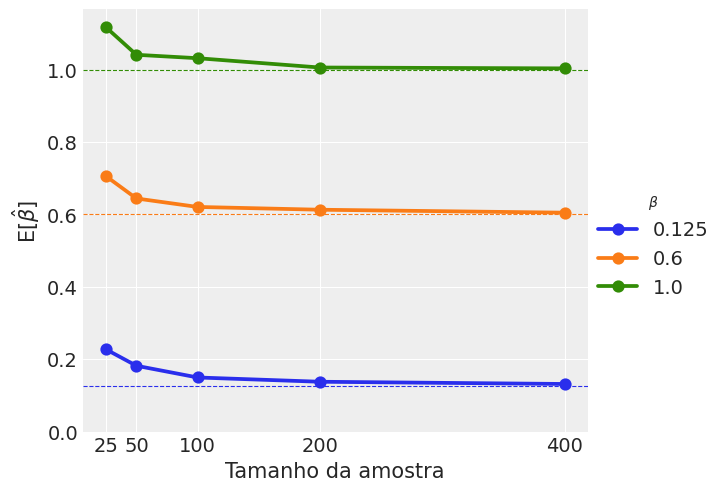

In [69]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="mean", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{E}[\hat{\beta}]$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

for label, color in zip(labels, sns.color_palette()):
    ax.axhline(float(label), color=color, linestyle="--", linewidth=0.8)

fig.savefig("img/classical/sim/mean.png")

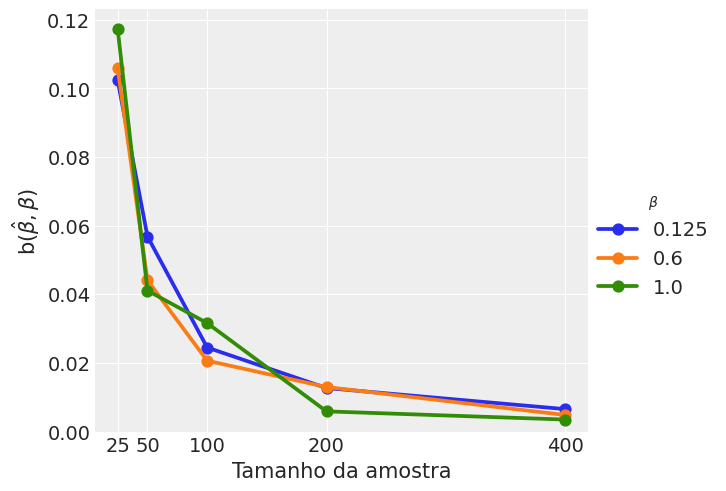

In [70]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="bias", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{b}(\hat{\beta}, \beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/classical/sim/bias.png")

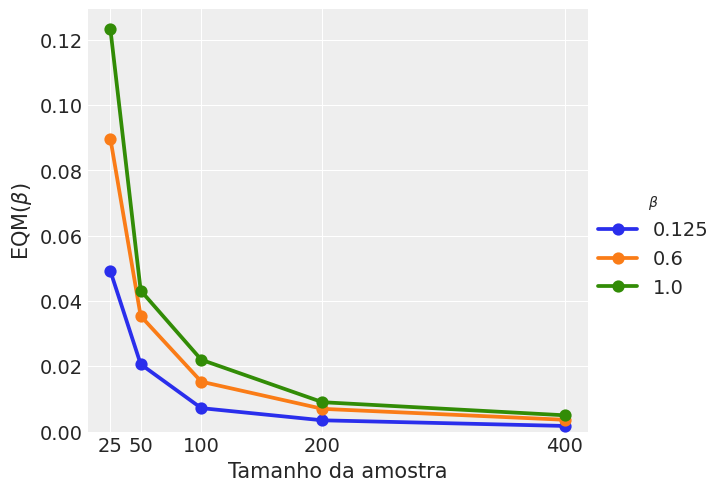

In [71]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="mse", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{EQM}(\beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/classical/sim/eqm.png")

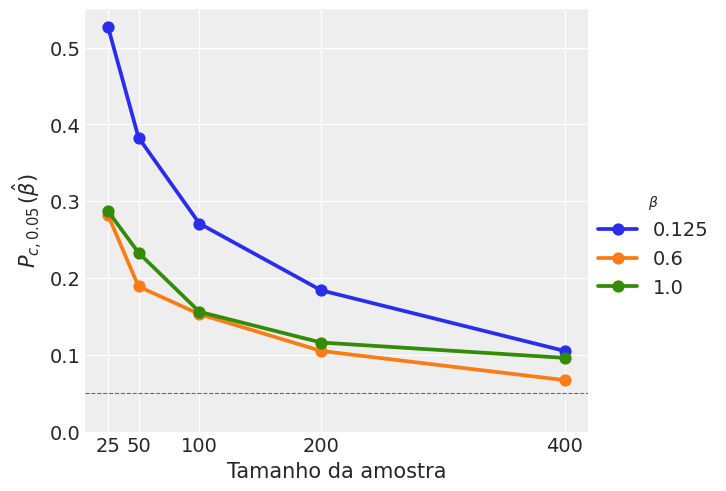

In [72]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="coverage_probability", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(f"$\\operatorname{{P_{{c, {ALPHA:.2f}}}}}(\\hat{{\\beta}})$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

ax.axhline(1 - ALPHA, color="dimgrey", linestyle="--", linewidth=0.8)

fig.savefig("img/classical/sim/pc.png")

# Estudo de simulação bayesiano

## Priori $\operatorname{Gama}(0.01, 0.001)$

\begin{align*}
    \beta &\sim \operatorname{Gama}(0.01, 0.001) \\
    X &\sim \operatorname{A}(\beta)
\end{align*}

In [ ]:
uninformative_simulations = {}

for beta in BETAS:
    uninformative_simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        uninformative_simulations[beta][n] = []
        print(f"\t{n = }")
        model = bayesian.make_model(
            sample = rv.rvs(size=n),
            prior=pm.Gamma,
            prior_params={"name": "beta", "alpha": 1, "beta": 1},
        )
        for i in range(REPLICATIONS):
            sample = rv.rvs(size=n)
            simulation = bayesian.simulate(
                param=beta,
                sample=sample,
                model=model,
                alpha=.05,
                sampler_params={
                    "draws": 1000,
                    "chains": 2,
                    "tune": 1000,
                    "target_accept": .99,
                    "random_seed": RNG,
                    "cores": 2
                }
            )
            uninformative_simulations[beta][n].append(simulation)

In [ ]:
uninformative_summaries = pd.DataFrame([
    summarize(uninformative_simulations[beta][n])
    for beta in uninformative_simulations
    for n in uninformative_simulations[beta]
])

In [ ]:
uninformative_summaries.to_csv("res/bayesian/sim/uninformative/summaries.csv", index=False)
uninformative_summaries

,true_param,sample_size,mean,bias,mse,coverage_probability
0,0.125,25,0.206174,0.081174,0.016074,1.0
1,0.125,50,0.204006,0.079006,0.028602,0.9
2,0.125,100,0.174386,0.049386,0.007326,0.9
3,0.125,200,0.136357,0.011357,0.002276,1.0
4,0.125,400,0.135674,0.010674,0.002763,0.9
5,0.600,25,0.578455,-0.021545,0.074279,1.0
6,0.600,50,0.512891,-0.087109,0.018255,1.0
7,0.600,100,0.617163,0.017163,0.010713,1.0
8,0.600,200,0.580703,-0.019297,0.008269,1.0
9,0.600,400,0.599855,-0.000145,0.003692,1.0


In [ ]:
simulation_results = pd.DataFrame([
    simulation
    for beta in uninformative_simulations
    for n in uninformative_simulations[beta]
    for simulation in uninformative_simulations[beta][n]
])
ci = (
    pd.json_normalize(simulation_results["ci"])
    .rename(columns=lambda col: f"ci_{col}")
)
simulation_results[ci.columns] = ci
simulation_results = simulation_results.drop("ci", axis=1)
simulation_results.to_csv("res/bayesian/sim/uninformative/simulations.csv", index=False)
simulation_results

,sample_size,true_param,estimated_param,ci_lower,ci_upper
0,25,0.125,0.259168,0.000056,0.518362
1,25,0.125,0.184061,0.000087,0.401447
2,25,0.125,0.106588,0.000525,0.253342
3,25,0.125,0.162327,0.001252,0.354293
4,25,0.125,0.157530,0.001129,0.357148
...,...,...,...,...,...
145,400,1.000,1.146036,0.990335,1.270746
146,400,1.000,1.116066,0.980194,1.254218
147,400,1.000,1.102070,0.961556,1.243154
148,400,1.000,0.915636,0.794141,1.049511


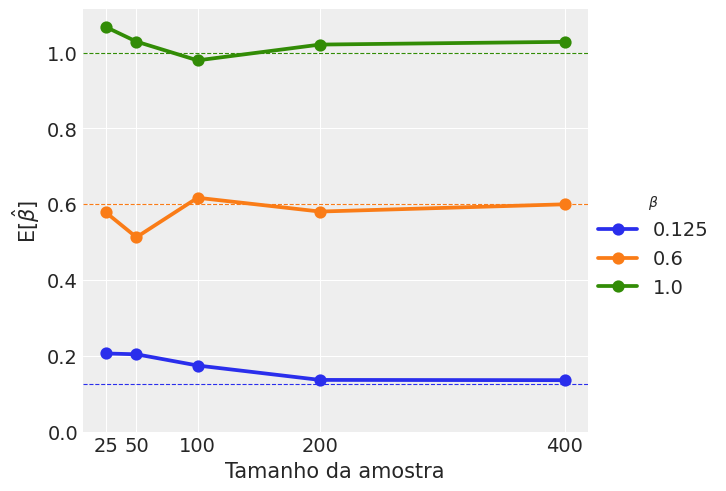

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="mean", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{E}[\hat{\beta}]$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

for label, color in zip(labels, sns.color_palette()):
    ax.axhline(float(label), color=color, linestyle="--", linewidth=0.8)

fig.savefig("img/bayesian/sim/uninformative/mean.png")

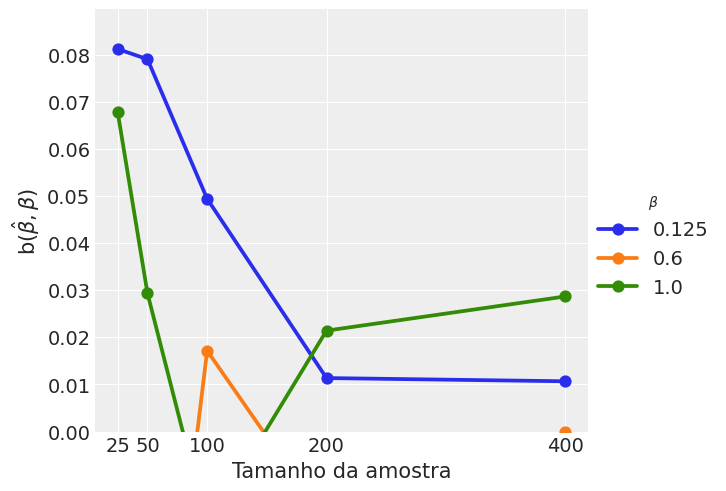

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries,
              x="sample_size", 
              y="bias", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{b}(\hat{\beta}, \beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/bayesian/sim/uninformative/bias.png")

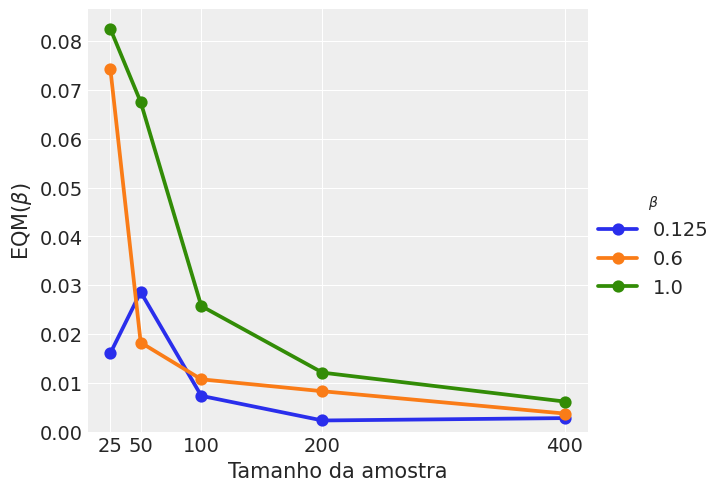

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="mse", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{EQM}(\beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/bayesian/sim/uninformative/eqm.png")

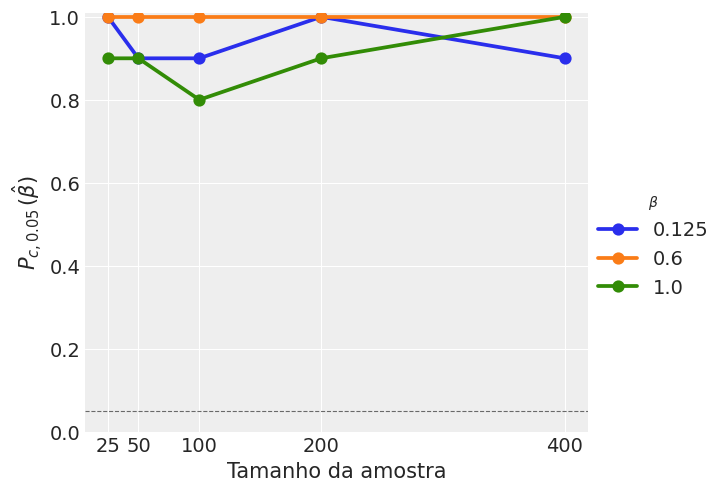

In [ ]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="coverage_probability", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(f"$\\operatorname{{P_{{c, {ALPHA:.2f}}}}}(\\hat{{\\beta}})$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

ax.axhline(1 - ALPHA, color="dimgrey", linestyle="--", linewidth=0.8)

fig.savefig("img/bayesian/sim/uninformative/pc.png")